In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import sort
#from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output

In [2]:
class myDict:
    def __init__(self,d):
        self.dic=d
    def normalize(self):
        a=np.array(list(self.dic.values()))
        return myDict(dict(zip(self.dic.keys(),(a-a.min())/a.max())))
    def __repr__(self):
        return str(self.dic)
    def __add__(self,other):
        return myDict(dict(pd.Series(self.dic)+pd.Series(other.dic)))
    def __truediv__(self,val):
        return myDict(dict(zip(self.dic.keys(),np.array(list(self.dic.values()))/val)))
    def keys(self):
        return self.dic.keys()
    def values(self):
        return self.dic.values()
    def get_sorted(self):
        a=list(zip(self.dic.keys(),self.dic.values()))
        return myDict(dict(sorted(a,key=lambda e:e[1])))
    
def get_feature_set_for(target_column):
    df=pd.read_csv('DataSet_54F.csv')#pd.read_csv("features_embedded.csv")
    #df['norm_road']=df[['Signal', 'bus_stop', 'Turn','Congestion']].apply(lambda e: 1 if e[0]==e[1]==e[2]==e[3]==0 else 0,axis=1)

    labels=df[target_column].values
    features=df.drop(columns=['Is_Bus_stop', 'Is_Turn', 'Is_Signal', 'Is_Congestion', 'Is_Adhoc'])

    #oversample = SMOTE()
    #features,labels = oversample.fit_resample(features,labels)
    return features,labels

In [3]:
def check_feature_accuracy(target_class,importance_dict):
    acc_mean_l=[]
    acc_std_l=[]
    fsize=len(importance_dict.keys())
    for feat in range(1,fsize+1):
        acc_l=[]
        taken_feat=list(importance_dict.keys())[-feat:]
        for _ in range(30):
            X,y=get_feature_set_for(target_class)
            X_train, X_test, y_train, y_test = train_test_split(X[taken_feat], y, test_size=0.33, random_state=None)
            
            #SMOTE ing only training set
            #oversample = SMOTE()
            #X_train,y_train = oversample.fit_resample(X_train,y_train)
            
            s=MinMaxScaler()
            X_train=s.fit_transform(X_train)
            X_test=s.transform(X_test)

            model = RandomForestClassifier()#n_estimators=20,max_depth=8)#XGBClassifier()
            model.fit(X_train, y_train)

            acc=(model.predict(X_test)==y_test).mean()
            acc_l.append(acc)
        acc_mean_l.append(np.mean(acc_l))
        acc_std_l.append(np.std(acc_l))

    return acc_mean_l,acc_std_l

In [4]:
def Feature_Importance(target_class,run_cases):
    feat_columns=\
    ['Is_Early_Morning', 'Is_Morning', 'Is_Afternoon', 'Is_Evening',
       'stay_duration', 'wifi_count', 'edge_wifi_count', 'honk_duration',
       'edge_honk_duration', 'd_wifi_count', 'd_edge_wifi_count',
       'd_honk_duration', 'd_edge_honk_duration', 'human_made', 'natural_land',
       'road_exist_percent', 'highly_populated_poi_exist', 'RSI']
    
    Sum=myDict(dict(zip(feat_columns,[0]*18))) #zero_initilization

    for _ in range(run_cases):
        X,y=get_feature_set_for(target_class)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=None)

        #SMOTE ing only training set
        #oversample = SMOTE()
        #X_train,y_train = oversample.fit_resample(X_train,y_train)
            
        s=MinMaxScaler()
        X_train=s.fit_transform(X_train)
        X_test=s.transform(X_test)
        
        print('{}: on run {}'.format(target_class,_))
        model = RandomForestClassifier()#n_estimators=20,max_depth=8)#XGBClassifier()
        model.fit(X_train, y_train)

        Sum+=myDict(dict(zip(X.columns,model.feature_importances_)))

    avg=Sum/run_cases
    avg=avg.get_sorted()
    
    print('checking feature adding accuracy')
    acc_mean_l_c,acc_std_l_c=check_feature_accuracy(target_class,avg)

    fig=plt.figure(figsize=(10,5))
    fig.suptitle(target_class,size=16)
    ax=fig.add_subplot(121)
    ax.barh(list(avg.keys()),list(avg.values()),color=sns.color_palette('hot_r',18))
    ax.set_xlabel('Importance')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax=fig.add_subplot(122)
    ax.errorbar(list(map(str,range(1,18+1))),acc_mean_l_c,yerr=acc_std_l_c,label=target_class,
                c='g',marker='>',alpha=0.7,linewidth=2,ecolor='b',linestyle='--',mfc='r')
    ax.set_xlabel('High-->Low importance')
    ax.set_ylabel('Testing_Accuracy')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper left')
    plt.close()
    
    return fig,avg,acc_mean_l_c,acc_std_l_c

In [5]:
all_list=['Is_Early_Morning', 'Is_Morning', 'Is_Afternoon', 'Is_Evening',
       'stay_duration', 'wifi_count', 'edge_wifi_count', 'honk_duration',
       'edge_honk_duration', 'd_wifi_count', 'd_edge_wifi_count',
       'd_honk_duration', 'd_edge_honk_duration', 'human_made', 'natural_land',
       'road_exist_percent', 'highly_populated_poi_exist', 'RSI']

def get_feature_number(taken_list):
    l=[]
    for n in taken_list:
        l.append(all_list.index(n))
    return l

In [6]:
fig_bus_stop,bus_stop_fi,bus_stop_acc,bus_stop_acc_std=Feature_Importance('Is_Bus_stop',100)
fig_norm_road,norm_road_fi,norm_road_acc,norm_road_acc_std=Feature_Importance('Is_Adhoc',100)
fig_Signal,Signal_fi,Signal_acc,Signal_acc_std=Feature_Importance('Is_Signal',100)
fig_Turn,Turn_fi,Turn_acc,Turn_acc_std=Feature_Importance('Is_Turn',100)
fig_Congestion,Congestion_fi,Congestion_acc,Congestion_acc_std=Feature_Importance('Is_Congestion',100)
clear_output()

# Feature Importance individual

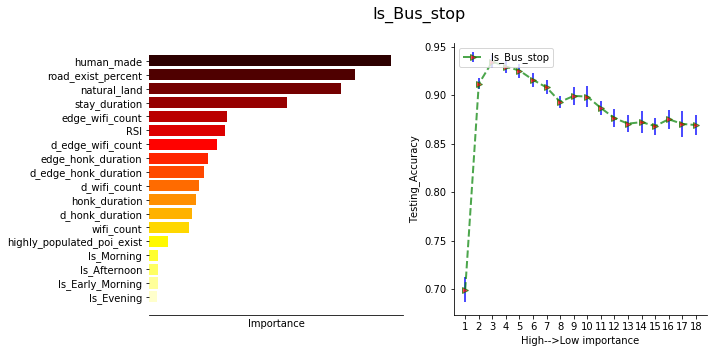

In [9]:
fig_bus_stop.savefig('./logs/Figures/bus_stop.png',bbox_inches='tight')
fig_bus_stop

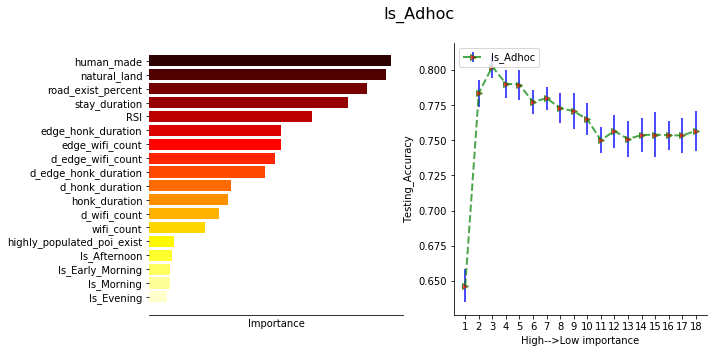

In [10]:
fig_norm_road.savefig('./logs/Figures/Adhoc.png',bbox_inches='tight')
fig_norm_road

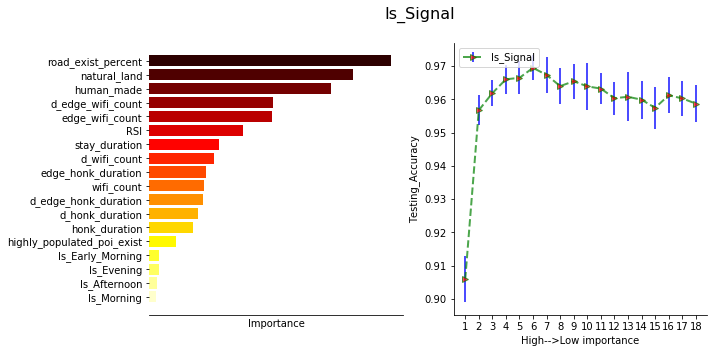

In [11]:
fig_Signal.savefig('./logs/Figures/Signal.png',bbox_inches='tight')
fig_Signal

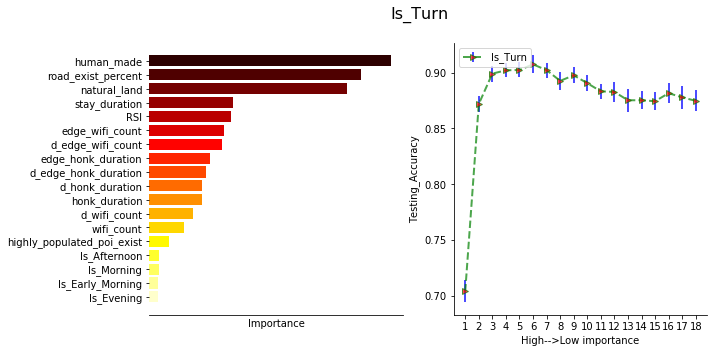

In [12]:
fig_Turn.savefig('./logs/Figures/Turn.png',bbox_inches='tight')
fig_Turn

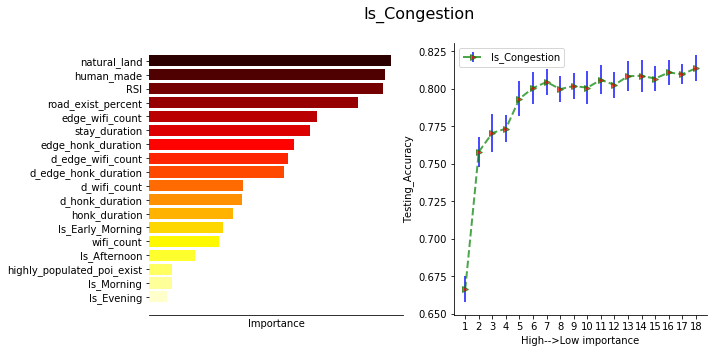

In [13]:
fig_Congestion.savefig('./logs/Figures/Congestion.png',bbox_inches='tight')
fig_Congestion

# Average Feature Importance

In [14]:
avg_importance=\
((bus_stop_fi.normalize()+\
norm_road_fi.normalize()+\
Signal_fi.normalize()+\
Turn_fi.normalize()+\
Congestion_fi.normalize())/5).get_sorted()

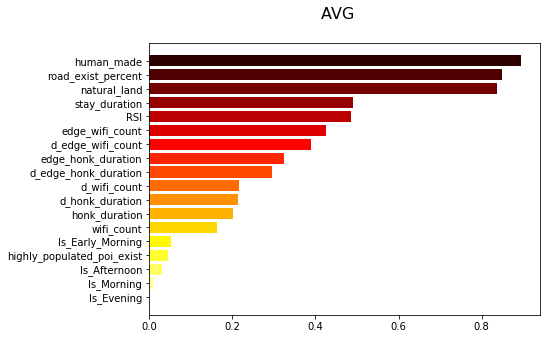

In [15]:
fig=plt.figure(figsize=(7,5))
fig.suptitle('AVG',size=16)
ax=fig.add_subplot(111)
ax.barh(list(avg_importance.keys()),list(avg_importance.values()),color=sns.color_palette('hot_r',18))
fig.savefig('./logs/Figures/Avg_imp.png',bbox_inches='tight')
plt.show()

In [16]:
#DONE

# For Average importance

In [17]:
bus_stopacc_mean_l,bus_stopacc_std_l=check_feature_accuracy('Is_Bus_stop',avg_importance)
norm_roadacc_mean_l,norm_roadacc_std_l=check_feature_accuracy('Is_Adhoc',avg_importance)
Signalacc_mean_l,Signalacc_std_l=check_feature_accuracy('Is_Signal',avg_importance)
Turnacc_mean_l,Turnacc_std_l=check_feature_accuracy('Is_Turn',avg_importance)
Congestionacc_mean_l,Congestionacc_std_l=check_feature_accuracy('Is_Congestion',avg_importance)

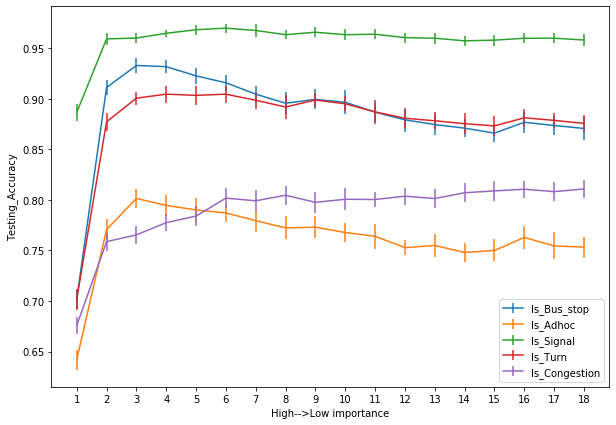

In [18]:
fig=plt.figure(figsize=(10,7))
ax=fig.add_subplot(111)
ax.errorbar(list(map(str,range(1,18+1))),bus_stopacc_mean_l,yerr=bus_stopacc_std_l,label='Is_Bus_stop')
ax.errorbar(list(map(str,range(1,18+1))),norm_roadacc_mean_l,yerr=norm_roadacc_std_l,label='Is_Adhoc')
ax.errorbar(list(map(str,range(1,18+1))),Signalacc_mean_l,yerr=Signalacc_std_l,label='Is_Signal')
ax.errorbar(list(map(str,range(1,18+1))),Turnacc_mean_l,yerr=Turnacc_std_l,label='Is_Turn')
ax.errorbar(list(map(str,range(1,18+1))),Congestionacc_mean_l,yerr=Congestionacc_std_l,label='Is_Congestion')
ax.set_xlabel('High-->Low importance')
ax.set_ylabel('Testing_Accuracy')
#ax.set_ylim(0,1)
ax.legend()
plt.show()
#fig.savefig('./logs/Figures/all_feat_acc_avg_imp.png',bbox_inches='tight')

# All in one_line_plot

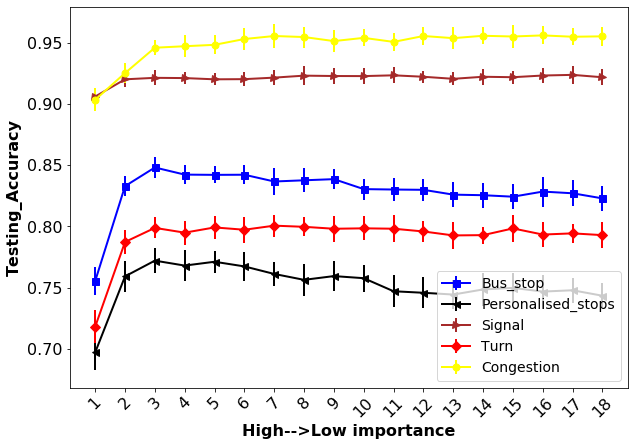

In [33]:
fig=plt.figure(figsize=(10,7))
ax=fig.add_subplot(111)
ax.errorbar(list(map(str,range(1,18+1))),bus_stop_acc,yerr=bus_stop_acc_std,label='Bus_stop',c='blue',
            marker='s',alpha=1.0,linewidth=2,linestyle='-',markersize=7)
ax.errorbar(list(map(str,range(1,18+1))),norm_road_acc,yerr=norm_road_acc_std,label='Personalised_stops',c='black',
            marker='<',alpha=1.0,linewidth=2,linestyle='-',markersize=7)
ax.errorbar(list(map(str,range(1,18+1))),Signal_acc,yerr=Signal_acc_std,label='Signal',c='brown',
            marker='>',alpha=1.0,linewidth=2,linestyle='-',markersize=7)
ax.errorbar(list(map(str,range(1,18+1))),Turn_acc,yerr=Turn_acc_std,label='Turn',c='red',
            marker='D',alpha=1.0,linewidth=2,linestyle='-',markersize=7)
ax.errorbar(list(map(str,range(1,18+1))),Congestion_acc,yerr=Congestion_acc_std,label='Congestion',c='yellow',
            marker='o',alpha=1.0,linewidth=2,linestyle='-',markersize=7)
ax.set_xlabel('High-->Low importance',fontdict={'size':16,'fontweight':'bold'})
ax.set_ylabel('Testing_Accuracy',fontdict={'size':16,'fontweight':'bold'})
ax.legend(loc='lower right',fontsize=14)
ax.tick_params(axis='x', labelrotation=45,labelsize=16)
ax.tick_params(axis='y', labelrotation=0,labelsize=16)
#fig.savefig('./Figures/all_feat_acc.png',bbox_inches='tight')
plt.show()

In [7]:
#NICE